# `SyntheticGenerator` tutorial

This tutorial demonstrates how to generate synthetic seismic along with horizons and faults using `seismiqb`. One can use generated data for training models for horizon/faults detection as well as models of impedance inversion.

By the end of the tutorial you will know two ways of generating synthetic data:
- chaining methods from `SyntheticGenerator` class
- running `generate_synthetic` wrapper function

You will also know how to control the parameters of `SyntheticGenerator` methods to generate synthetic slides that suit your needs.

In [494]:
# All necessary imports
import sys
import shutil
sys.path.insert(0, '..')

from seismiqb import generate_synthetic, SyntheticGenerator, plot, Horizon, Field, SeismicDataset
from seismiqb.src.geometry.export import make_segy_from_array

## Using `SyntheticGenerator` class

In order to create synthetic seismic using `SyntheticGenerator` class one must chain methods for

- generation of a range of velocities
- generation of velocity-model
- adding faults (optionaly)
- making density-model
- making reflectivity coefficients
- generation synthetic-model
- postprocessing synthetic model (optinally)

from a class instance. For reproducibility purposes `SyntheticGenerator` instance can be initiated with a seed:

In [495]:
generator = SyntheticGenerator(seed=100)

In [496]:
%%time
generator = (generator.make_velocities(num_reflections=60, horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                       horizon_multipliers=(-14, 16, -11, 10))
                      .make_velocity_model((200, 500), (10, ))
                      .add_faults(faults_coordinates=(((100, 100), (120, 220)),
                                                      ((150, 340), (190, 470))), max_shift=13,
                                  zeros_share=0.2)
                      .make_density_model((0.98, 1.02))
                      .make_reflectivity()
                      .make_synthetic()
                      .postprocess_synthetic(noise_mul=0.0))

CPU times: user 54.6 ms, sys: 0 ns, total: 54.6 ms
Wall time: 51.8 ms


check out generated synthetic along with corresponding velocity model and computed reflectivity coefficients:

In [497]:
import numpy as np

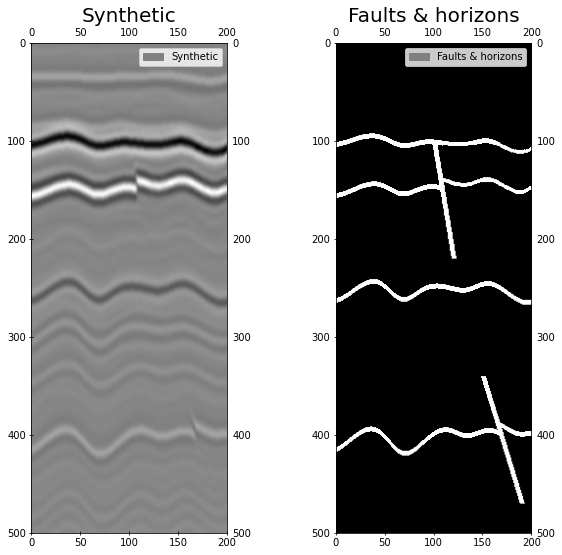

In [499]:
plot([generator.synthetic,
     np.maximum(generator.fetch_faults(), generator.fetch_horizons(horizon_format='mask'))], combine='separate',
     label=['Synthetic', 'Faults & horizons'],
     cmap='gray', figsize=(10, 9))

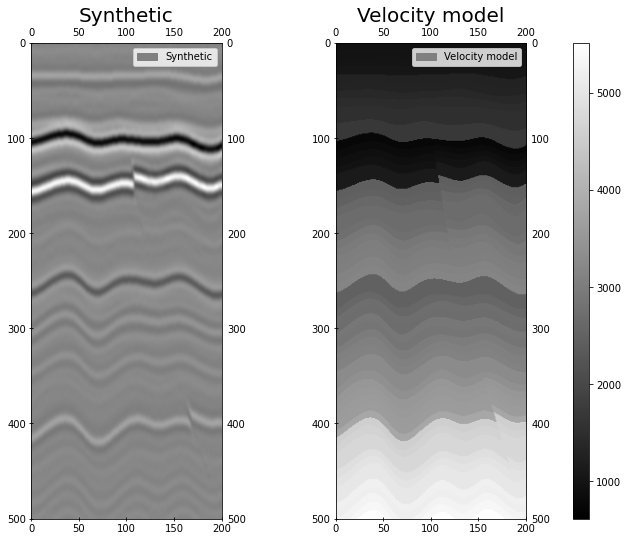

In [500]:
plot([generator.synthetic, generator.velocity_model], combine='separate',
     label=['Synthetic', 'Velocity model'],
     cmap='gray', figsize=(10, 9), colorbar=[False, True])

## Tweaking the parameters of synthetic generation

### *num_reflections* in `make_velocities`

The general "look" of a seismic slide is strongly influenced by the number of reflections (layers on velocity model. Increase the value of this parameter to make seismic look more interesting. Do not go overboard with the number of reflections. Default ricker frequency cannot discern large number of small jumps in velocity model. As the result, large number of reflections will only lead to more noise in synthetic:

In [506]:
reflections = [10, 30, 50, 100, 200, 300]
slides = []

In [507]:
for num_reflections in reflections:
    generator = (generator.make_velocities(num_reflections=num_reflections,
                                           horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                           horizon_multipliers=(-8, 8, -7, 9))
                          .make_velocity_model((200, 800), (10, ))
                          .make_density_model((.99, 1.01))
                          .make_reflectivity()
                          .make_synthetic()
                          .postprocess_synthetic(noise_mul=0.2))
    slides.append(generator.synthetic)

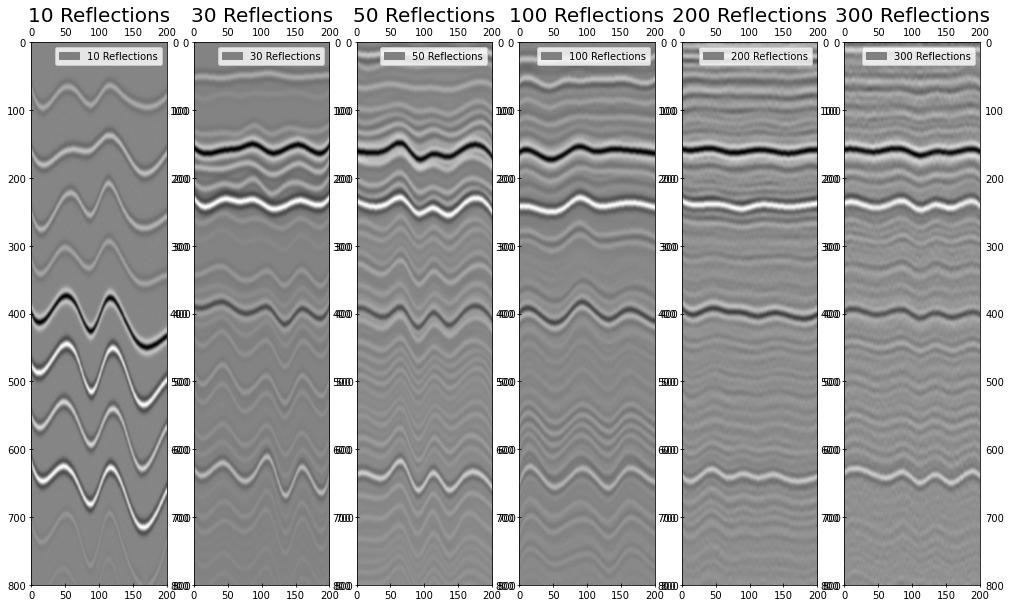

In [508]:
plot(slides, cmap='gray', combine='separate', figsize=(17, 10),
     label=[f'{num} Reflections' for num in reflections])

### *horizon_heights* and *horizon_jumps* in `make_velocities`

These two parameters control the number of horizons (sharp, most visible reflections), their heights (in shares of 1) and their magnitide. The magnitide is controlled by multiplier jumps relative to the common difference in velocities between layers. Large negative jumps correspond to black horizons, large positive - to white ones. Pick jumps that are to small - and you won't find any horizons at all (all of the reflections become horizons):

In [509]:
heights = [(0.2, 0.5), (0.3, 0.8), (.1, .6), (.2, .4), (.2, .9)]
magnitudes =[(-2, 2), (-5, 4), (9, -8), (-16, 20), (35, -27)]
slides = []

In [510]:
for hs, magns in zip(heights, magnitudes):
    generator = (generator.make_velocities(num_reflections=100,
                                           horizon_heights=hs, horizon_multipliers=magns)
                          .make_velocity_model((200, 800), (10, ))
                          .make_density_model((.97, 1.03))
                          .make_reflectivity()
                          .make_synthetic()
                          .postprocess_synthetic(noise_mul=0.2))
    slides.append(generator.synthetic)

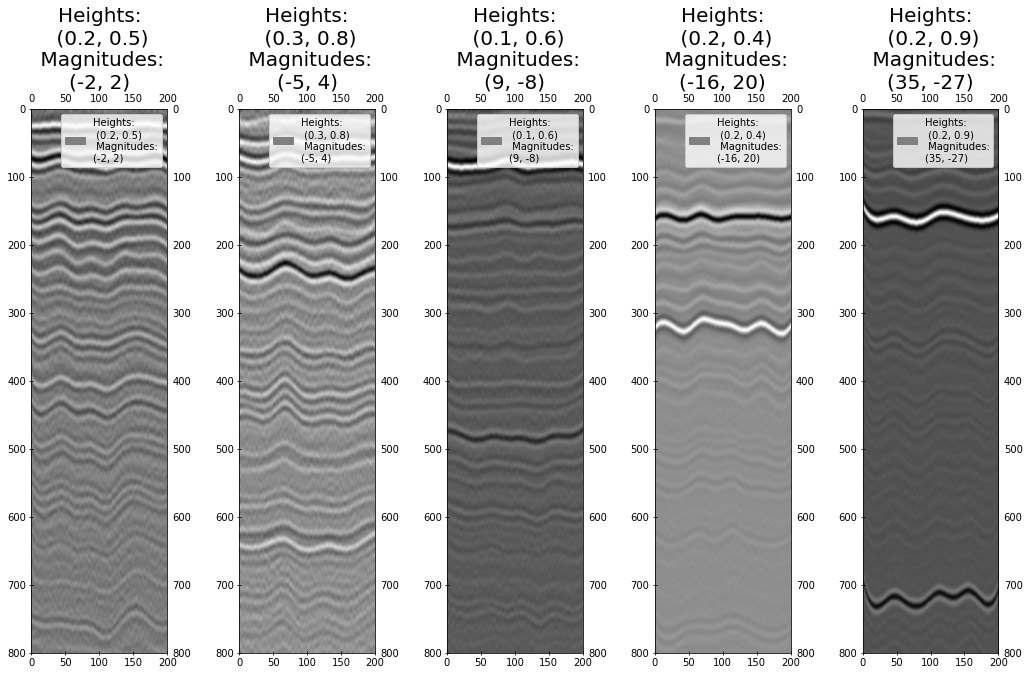

In [511]:
plot(slides, cmap='gray', combine='separate', figsize=(18, 10),
     label=[f'Heights:\n {hs}\n Magnitudes:\n{magns}' for hs, magns in zip(heights, magnitudes)])

### *density_noise_lims* in `make_density_model`

In `SyntheticGenerator` `density_model` is given by `noise * velocity_model`. As the result, you can increase the sharpness of horizons by decreasing noise range. However, go to small (reduce the noise range to `[1, 1]`) and the synthetic will become unrealistically sharp:

In [512]:
es = [0.3, 0.2, 0.07, 0.03, 0]
noise_ranges = [(1 - e, 1 + e) for e in es]
slides = []

In [513]:
for noise_lims in noise_ranges:
    generator = (generator.make_velocities(num_reflections=60,
                                           horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                           horizon_multipliers=(-8, 8, -7, 9))
                          .make_velocity_model((200, 800), (10, ))
                          .make_density_model(density_noise_lims=noise_lims)
                          .make_reflectivity()
                          .make_synthetic()
                          .postprocess_synthetic(noise_mul=0.2)
                )
    slides.append(generator.synthetic)

In [515]:
plot(slides, cmap='gray', combine='separate', figsize=(16, 10),
     label=[f'Noise range:\n ({1 - e:.3f}, {1 + e:.3f}) ' for e in es])

### *grid_shape* and *perturbation_share* in `make_velocity_model`

To form the layers of velocity model we use horizontal surfaces, randomly perturbed in grid-points. To control the heights' variability of a surface use parameters `grid_shape` and `perturbation_share`.

On one hand, you can make each surface more volatile, increasing the amount of grid-points in which surfaces' heights are sampled. On the other hand, you can achieve more volatility, increasing perturbation range for surfaces' heights in a node. Note that `perturbation_share`-parameter is set in shares of typical distance between subsequent surfaces:

In [326]:
grids = [(7, ), (7, ), (7, ), (10, ), (14, ), (18, )]
perturbations_shares = [.01, .1, .4, .2, .2, .2]

slides = []

In [327]:
for grid, share in zip(grids, perturbations_shares):
    generator = (generator.make_velocities(num_reflections=60,
                                           horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                           horizon_multipliers=(-8, 8, -7, 9))
                          .make_velocity_model((200, 800), grid_shape=grid,
                                               perturbation_share=share)
                          .make_density_model(density_noise_lims=(0.99, 1.01))
                          .make_reflectivity()
                          .make_synthetic()
                          .postprocess_synthetic(noise_mul=0.2))
    slides.append(generator.synthetic)

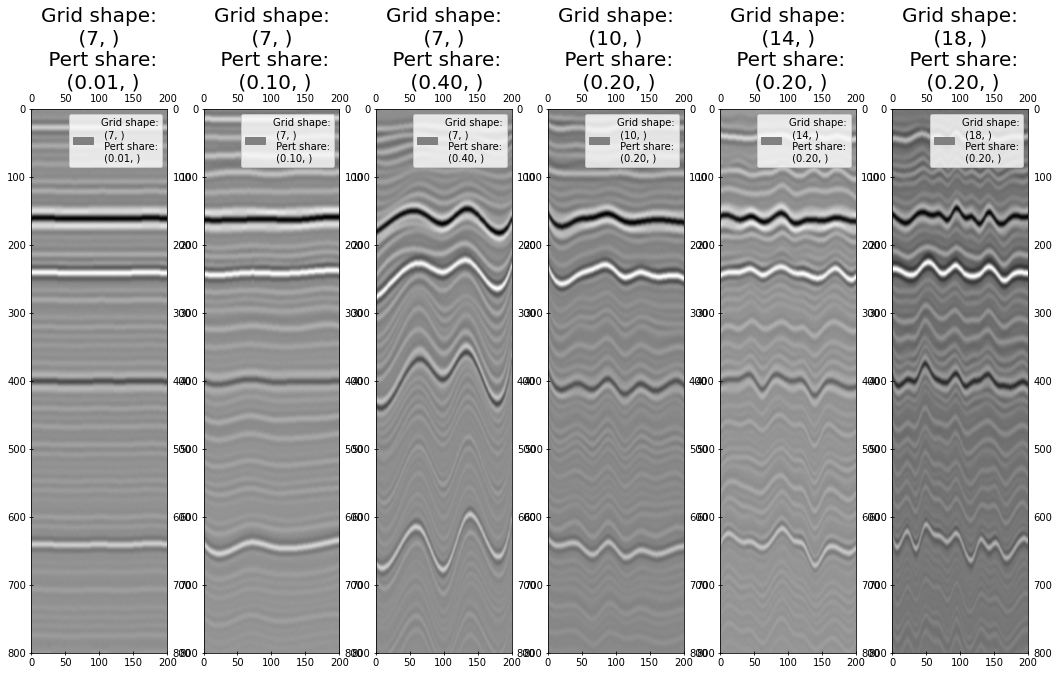

In [328]:
plot(slides, cmap=['gray'] * len(slides), combine='separate', figsize=(18, 10),
     label=[f'Grid shape:\n ({grid[0]}, ) \n Pert share:\n ({share:.2f}, )'
            for grid, share in zip(grids, perturbations_shares)])

### `add_faults`-method of `SyntheticGenerator`

To make synthetic more interesting and for training faults' detection models, add faults on a synthetic slide.

For now, faults are only supported for 2d-seismic. The natural way to describe faults is by their coordinates. A fault's location is set by its coordinates `([x0, y0], [x1, y1])`:

```
coords_of_three_faults = ([(100, 100), (150, 200)],
                          [(80, 200), (100, 270)],
                          [(150, 300), (130, 400)])
```
To make faults more visible, (i) put them close to horizons and (ii) control *max_shift*-parameter. The latter is in depth units and controls how large are the faults:

In [574]:
shifts = [1, 5, 15, 25, 40]

slides = []

In [575]:
for shift in shifts:
    generator = SyntheticGenerator(seed=90)
    generator = (generator.make_velocities(num_reflections=80, horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                           horizon_multipliers=(-8, 8, -7, 9))
                          .make_velocity_model((200, 800), (10, ))
                          .add_faults(faults_coordinates=(((100, 100), (120, 220)),
                                                          ((150, 600), (180, 720))),
                                      max_shift=shift,
                                      zeros_share=0.4)
                          .make_density_model((.99, 1.01))
                          .make_reflectivity()
                          .make_synthetic()
                          .postprocess_synthetic(noise_mul=0.2))
    slides.append(generator.synthetic)

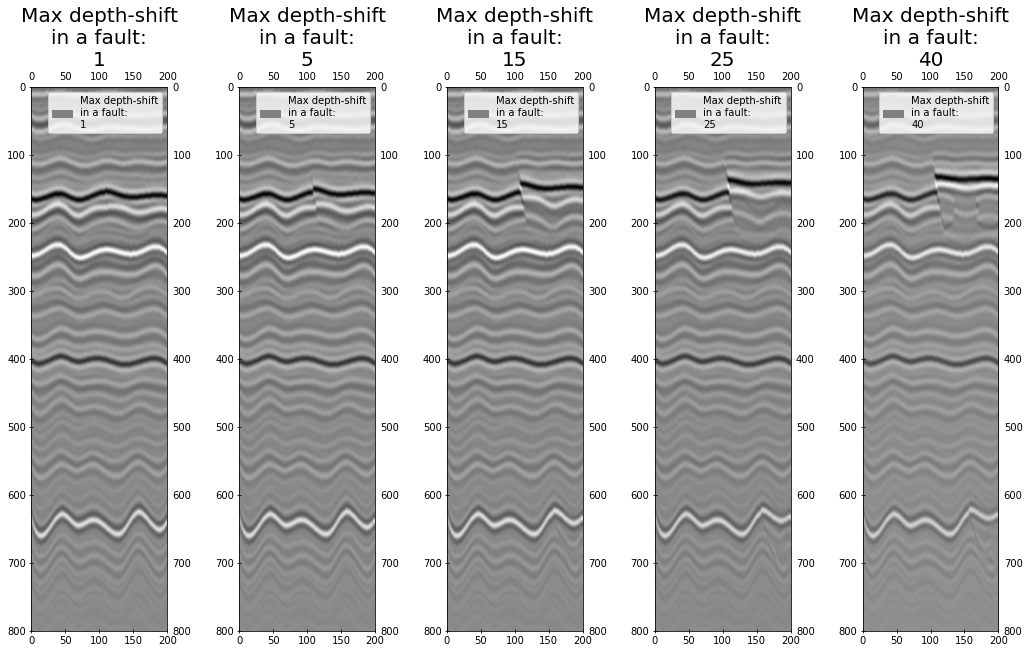

In [576]:
plot(slides, cmap='gray', combine='separate', figsize=(18, 10),
     label=[f'Max depth-shift\nin a fault:\n{shift}' for shift in shifts])

Note that each fault affects the synthetic the most at its center and the least at its origin point `(x0, y0)` and end point `(x1, y1)`. Use *zeros_share* parameter to control how fast the effect of a fault drops when moving closer to `(x0, y0)` and `(x1, y1)`:

In [591]:
zeros_shares = [0.0, 0.1, 0.4, 0.8]

slides = []

In [592]:
for zeros_share in zeros_shares:
    generator = SyntheticGenerator(seed=10)
    generator = (generator.make_velocities(num_reflections=80, horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                           horizon_multipliers=(-8, 8, -7, 9))
                          .make_velocity_model((200, 800), (10, ))
                          .add_faults(faults_coordinates=(((100, 100), (120, 220)),
                                                          ((150, 600), (180, 720))),
                                      max_shift=17,
                                      zeros_share=zeros_share)
                          .make_density_model((.99, 1.01))
                          .make_reflectivity()
                          .make_synthetic()
                          .postprocess_synthetic(noise_mul=0.2))
    slides.append(generator.synthetic)

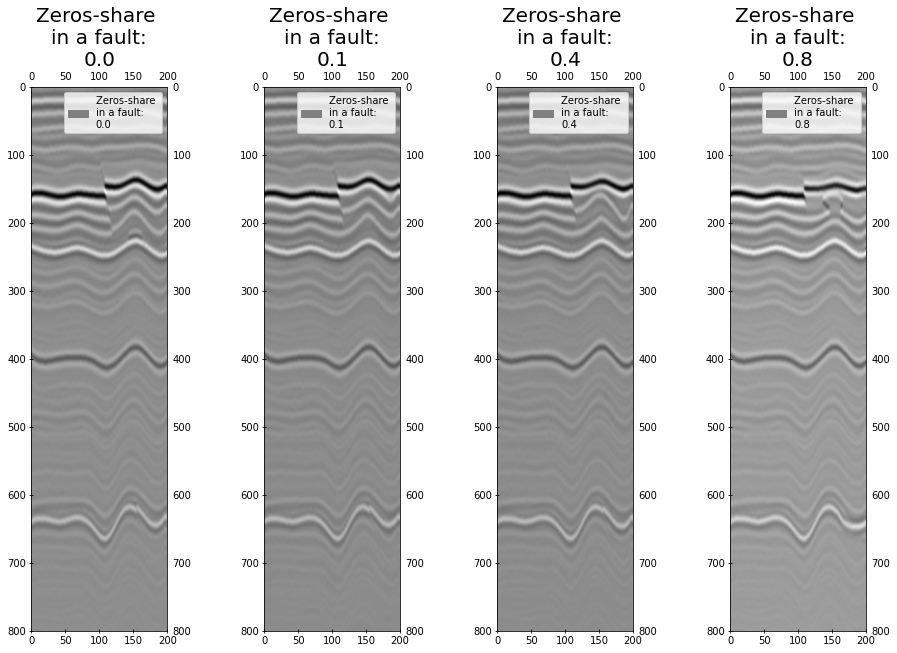

In [593]:
plot(slides, cmap='gray', combine='separate', figsize=(16, 10),
     label=[f'Zeros-share \nin a fault:\n{share}' for share in zeros_shares])

## Using `generate_synthetic` wrapper to generate seismic

a bit simpler way involves using `generate_synthetic` wrapper function. All parameters need to be supplied at once:

In [533]:
%%time
synthetic, mask, _ = generate_synthetic(shape=(200, 600), grid_shape=10, num_reflections=40,
                                        horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                        horizon_multipliers=(-8, 8, -7, 9),
                                        faults_coordinates=(((100, 100), (120, 220)),
                                                            ((150, 320), (180, 420))),
                                        zeros_share_faults=0.2, seed=100,
                                        max_shift=14,
                                        noise_mul=0.2)

CPU times: user 49 ms, sys: 5.82 ms, total: 54.8 ms
Wall time: 52.6 ms


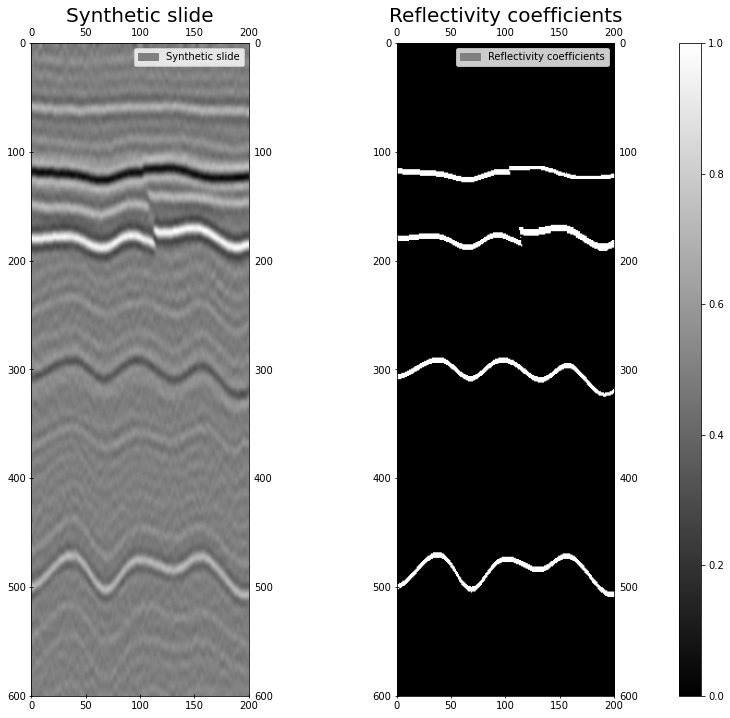

In [534]:
plot([synthetic, mask], combine='separate', cmap=['gray', 'gray'],
     label=['Synthetic slide', 'Reflectivity coefficients'], colorbar=[False, True])

## `dump` and `load` synthetic cube with `seismiqb`

Let's create a 3d-synthetic cube

In [553]:
%%time
synt3d, hors, _ = generate_synthetic(shape=(150, 150, 200), grid_shape=(10, 10),
                                     num_reflections=60,
                                     geobodies_format=('heights', 'mask'))

CPU times: user 525 ms, sys: 127 ms, total: 652 ms
Wall time: 650 ms


naturally, one can dump the cube on disk

In [554]:
%%time
make_segy_from_array(synt3d, 'cube_test.sgy', zip_segy=False)

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 1.05 s, sys: 688 ms, total: 1.74 s
Wall time: 1.59 s


/opt/conda/lib/python3.6/site-packages/segyio/utils.py:23: RuntimeWarning:

Implicit conversion from float64 to float32 (narrowing)



dump the horizons

In [555]:
field = Field('./cube_test.sgy')

Finding min/max: 0it [00:00, ?it/s]

Finding min/max:   0%|                                                                                        …

In [556]:
import os
from glob import glob

In [557]:
horizons = [Horizon(hor, field, 'synthetic_' + str(i)) for i, hor in enumerate(hors)]

In [558]:
if not os.path.exists('./test_horizons'):
    os.mkdir('./test_horizons')
for i, horizon in enumerate(horizons):
    horizon.dump('./test_horizons/hor_{}.txt'.format(i))

and `load` both cube and horizons using `seismiqb`:

In [559]:
cubes = {'./cube_test.sgy': './test_horizons/*'}
ds = SeismicDataset(cubes, labels_class='horizon', collect_stats=True)

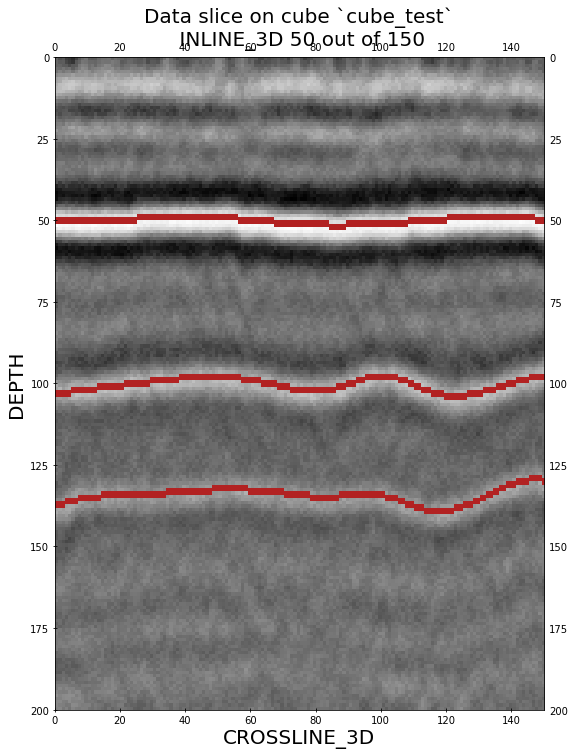

In [560]:
ds.show_slide(50)

clean-up: removing everything

In [563]:
import shutil

In [564]:
for path in ['./cube_test.meta', './cube_test.sgy', './test_horizons/', './CUBE_INFO.log']:
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)